In [96]:
from common import *
from gensim.models.wrappers import FastText
from matplotlib import pyplot as plt

import io
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
import ujson

with GzipFile('../data/corpus_json.txt.gz', 'r') as fr:
    with io.open('../data/corpus_ft.txt', 'w', encoding='utf8') as fw:
        for line in fr:
            _id, sents = ujson.loads(line)
            text = u' '.join([u' '.join(s) for s in sents])
            fw.write(text)

In [1]:
# model = FastText.train('/root/fastText/fasttext', '../data/_corpus_raw.txt', 
#                        size=100, 
#                        model='skipgram',
#                        window=5, 
#                        min_count=5, 
#                        iter=5,
#                        threads=cpu_count)

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format('../data/ft_output.vec')

2017-10-04 06:58:44,891 [MainThread  ] [INFO ]  loading projection weights from ../data/ft_output.vec
2017-10-04 07:04:16,667 [MainThread  ] [INFO ]  loaded (1750013, 100) matrix from ../data/ft_output.vec


In [12]:
most = model.most_similar(u'стол', topn=10)
for w, score in most:
    print(w + ', %s' % score)

столешница, 0.850950598717
столик, 0.845724821091
столешня, 0.836186289787
столешник, 0.828145384789
столешнище, 0.825657963753
стол-держатель, 0.816149771214
стол-тележка, 0.811580240726
стол-станина, 0.80703753233
стол-каталка, 0.80609112978
столиковый, 0.805907487869


In [13]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [15]:
wv = model.wv

In [ ]:
vecs = []
ids = []
with GzipFile('../data/corpus_json.txt.gz', 'r') as fr:
    for line in tqdm_notebook(fr):
        _id, sents = ujson.loads(line)
        word_vecs = np.array([wv[w] for s in sents for w in s if w in wv], dtype=np.float32)
        if len(word_vecs):
            doc_vec = word_vecs.mean(axis=0)
            vecs.append(doc_vec)
            ids.append(_id)

In [ ]:
# np.save('../data/saved/vecs_ft.npy', vecs)
# np.save('../data/saved/ids_ft.npy', ids)

In [89]:
vecs = np.load('../data/saved/vecs_ft.npy')
ids = np.load('../data/saved/ids_ft.npy')

In [90]:
def predict(keys, lim=200):
    names = pd.Series(range(len(ids)), index = ids)
    test_vecs = []
    for k in keys:
        ix = names[k]
        if isinstance(ix, pd.Series):
            ix = ix[0]
        tvec = vecs[ix]
        test_vecs.append(tvec)

    dists = euclidean_distances(test_vecs, vecs)
    sorted_ixs = np.argsort(dists, axis=1)
    preds = {}
    for k, _ixs in zip(keys, sorted_ixs):
        preds[k] = [n for n in ids[_ixs[1:lim+1]]]
        
    return preds

In [91]:
preds = predict(gold.keys(), lim=200)

100%|██████████| 184/184 [00:00<00:00, 25473.72it/s]


median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.267391
acc20     0.327174
acc200    0.543841
dtype: float64


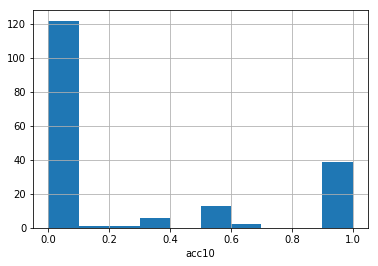

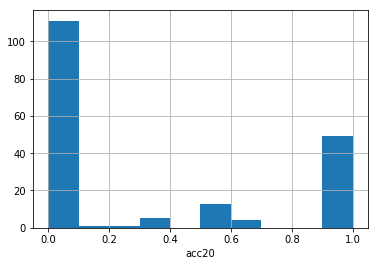

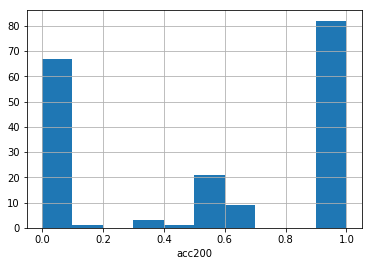

In [98]:
result = evaluate(preds, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()